# File d'attente

In [1]:
import random
from math import log, exp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy
import seaborn as sns
import itertools
from tqdm.notebook import trange, tqdm
from p_tqdm import p_map
import time
from tools import PDF
pdf = PDF("img/2_Weibull/")
import time
t = time.time()

In [2]:
import os
import platform
CPU_COUNT = os.cpu_count()
LOW_CPU = False
if CPU_COUNT < 56:
    LOW_CPU = True
MULTIPROCESSING = True
if platform.system() == 'Windows':
    MULTIPROCESSING = False
print(f"CPU count : {CPU_COUNT}")
print(f"Multiprocessing available : {MULTIPROCESSING}")

CPU count : 56
Multiprocessing available : True


## Question 4 
### Modélisation d'une loi de Weibull  
On utilise la méthode d'inversion : 

In [3]:
def wei_gen(lambda_,k, u=None):
    if u is None:
        u=random.random()
    return (lambda_*((-log(1-u))**(1/k)))

In [4]:
wei_gen(2,2)

1.5336934474739408

In [5]:
wei_gen(2,2,u=0.5)

1.6651092223153954

In [6]:
wei_gen(2,2,u=0.5)

1.6651092223153954

**Vérification**

In [7]:
k=2

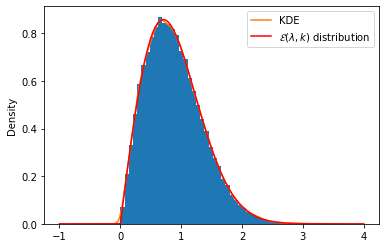

KstestResult(statistic=0.002624995201351371, pvalue=0.49521537916427705)


In [8]:
liste = [wei_gen(1,k) for i in range(100000)]

def test_exp(liste,lambda_=1,k=2):
    plt.hist(liste, density=True, bins=50)
    sns.kdeplot(liste, label="KDE")

    xx = np.linspace(-1, +4, 10000) 
    yy = stats.exponweib.pdf(xx,lambda_,k)
    plt.plot(xx, yy, 'r', label="$\mathcal{E}(\lambda,k)$ distribution")    
    plt.legend()
    plt.show()

    print(scipy.stats.kstest(liste, 'exponweib',args=(lambda_,k)))

test_exp(liste)

### Simulation de la file d'attente 

In [9]:
def file_attente(lambda1, lambda2, k1, k2, t, simplification=False, liste_dates_arrivée=None, liste_u=None):
    """
    liste_dates_arrivées et liste_u : seulement pour les méthodes v1 et v2
    """
    if liste_dates_arrivée is None:
        # On simule d'abord toutes les arrivées des clients
        liste_dates_arrivée = [wei_gen(lambda1,k1)]
        temps_nouveau_client = wei_gen(lambda1,k2)
        while liste_dates_arrivée[-1] + temps_nouveau_client <= t:
            liste_dates_arrivée.append(liste_dates_arrivée[-1] + temps_nouveau_client)
            temps_nouveau_client = wei_gen(lambda1,k1)
    
    n_clients = len(liste_dates_arrivée)
    
    if liste_u is None:
        # On simule les temps de service de chaque client
        liste_temps_service = [wei_gen(lambda2, k2) for _ in range(n_clients)]
    else:
        liste_temps_service = [wei_gen(lambda2, k2, liste_u[i]) for i in range(n_clients)]
    
    # On calcule enfin les dates de début et de fin de service de chaque client
    num_client = 0
    date_arrivée = liste_dates_arrivée[num_client]
    temps_service = liste_temps_service[num_client]
    # Le premier client est servi dès son arrivée
    date_début_service = date_arrivée
    date_fin_service = date_début_service + temps_service
    
    liste_dates_début_service = [date_début_service]
    liste_dates_fin_service = [date_fin_service]    
    
    while num_client < n_clients-1:
        num_client += 1
        date_arrivée = liste_dates_arrivée[num_client]
        temps_service = liste_temps_service[num_client]
        
        if date_arrivée >= liste_dates_fin_service[-1]:
            # Si le client arrive après la fin de service du client précédent,
            # il est servi tout de suite
            date_début_service = date_arrivée            
            date_fin_service = date_début_service + temps_service
        else:
            # Sinon le client est servi à l'instant de la fin de service du client précédent
            date_début_service = liste_dates_fin_service[-1]
            date_fin_service = date_début_service + temps_service      

        liste_dates_début_service.append(date_début_service)
        liste_dates_fin_service.append(date_fin_service) 
        
        if simplification and date_fin_service > t:
            break

    l = len(liste_dates_début_service)
    if l < n_clients:
        liste_dates_début_service += [None for i in range(n_clients - l)]
        liste_dates_fin_service += [None for i in range(n_clients - l)]
        
    dico = {"Date arrivée client": liste_dates_arrivée, 
            "Date début service": liste_dates_début_service,
            "Temps service": liste_temps_service,
            "Date fin service": liste_dates_fin_service}
    
    return pd.DataFrame(dico)

In [10]:
def search_t(X, t):
    """
    Renvoie i tel que X[i] <= t et X[i+1] >= t
    """
    if t in X:
        return X.index(t)    
    else:
        xt = 0
        while xt <= len(X)-2:
            if X[xt+1] < t:
                xt += 1
            else:
                return xt
        return xt


def nb_client_instant(data, n, t, plot=True, pdf=None):
    """
    Renvoie True si dépassement du seuil n
    False sinon
    """
    X = [0]
    Y = [0]
    
    liste_dates_arrivée = list(data["Date arrivée client"])
    liste_dates_départ = list(data["Date fin service"])
    
    while len(liste_dates_arrivée) > 0 and len(liste_dates_départ) > 0:
        date_arrivée = liste_dates_arrivée[0]
        date_départ = liste_dates_départ[0]
        
        if date_arrivée <= date_départ:
            date = liste_dates_arrivée.pop(0)
            X.append(date)
            Y.append(Y[-1] + 1)
        else:
            date = liste_dates_départ.pop(0)
            X.append(date)
            Y.append(Y[-1] - 1)
    
    while len(liste_dates_arrivée) > 0 :
        date_arrivée = liste_dates_arrivée.pop(0)
        X.append(date_arrivée)
        Y.append(Y[-1] + 1)
        
    while len(liste_dates_départ) > 0 :
        date_départ = liste_dates_départ.pop(0)
        X.append(date_départ)
        Y.append(Y[-1] - 1)
    
    xt = search_t(X,t)

    if plot:
        plt.scatter(X[1:xt+1],Y[1:xt+1])
        plt.scatter(X[xt+1:],Y[xt+1:], c="#C2C2C2")
        for i in range(xt):
            plt.hlines(Y[i], X[i], X[i+1])
            plt.vlines(X[i+1], Y[i], Y[i+1])
        if xt+1 < len(X):
            plt.hlines(Y[xt], X[xt], X[xt+1])
            plt.vlines(X[xt+1], Y[xt], Y[xt+1], color="#C2C2C2")
        for i in range(xt+1, len(X)-1):
            plt.hlines(Y[i], X[i], X[i+1], color="#C2C2C2")
            plt.vlines(X[i+1], Y[i], Y[i+1], color="#C2C2C2")
        plt.axhline(n, c="r", linestyle="--", label="Seuil de clients")
        plt.axvline(t, c="g", label="Date t")
        plt.legend()
        plt.xlabel("Temps")
        plt.ylabel("Nombre de clients")
        if pdf is not None:
            pdf.export()
        plt.show()

    if max(Y[:xt+1]) > n:
        return True
    else:
        return False

In [11]:
def simulation(lambda1, lambda2, k1, k2, n, t, plot=False, simplification=True, liste_dates_arrivée=None, liste_u=None):
    """
    Combine les fonctions file_attente et nb_client_instant
    """

    data = file_attente(lambda1, lambda2, k1, k2, t, simplification=simplification, liste_dates_arrivée=liste_dates_arrivée, liste_u=liste_u)
    return nb_client_instant(data, n, t, plot=plot)

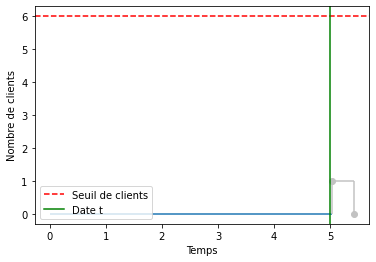

False

In [12]:
simulation(2, 2, 0.5, 1, 6, 5, plot=True, simplification=False)

### Estimation de la probabilité 

In [13]:
def proba_N_simul_v0(lambda1, lambda2, k1, k2, n, t, N_simul, multiproc=False):
    """
    Proba d'un dépassement du nombre de clients
    """
    def f_(_):
        return simulation(lambda1, lambda2, k1, k2, n, t)
    if multiproc:
        resultat = p_map(f_, [0]*N_simul)
    else:
        resultat = list(map(f_, [0]*N_simul))        
    return (np.sum(resultat) / len(resultat))

In [14]:
%%time
proba_N_simul_v0(1, 2, 0.5, 1, 6, 5, N_simul=10000, multiproc=False)

CPU times: user 6.52 s, sys: 0 ns, total: 6.52 s
Wall time: 6.52 s


0.1107

### Influence des paramètres
On calcule la proba sur de nombreuses combinaisons de paramètres.

In [15]:
def dico_proba(args):
    (lambda1, lambda2, k1, k2, n, t) = args
    return {"lambda1": lambda1,
             "lambda2": lambda2,
            "k1":k1,
            "k2":k2,
             "n": n,
             "t": t,
             "proba": proba_N_simul_v0(lambda1, lambda2, k1, k2, n, t, N_simul=500)}

In [16]:
import itertools

In [17]:
from tqdm.notebook import trange, tqdm
from p_tqdm import p_map

In [18]:
%%time

LIST_LAMBDA1 = np.linspace(0.1, 5, 8)
LIST_LAMBDA2 = np.linspace(0.1, 5, 8)
LIST_K1 = np.linspace(0.1, 5, 8)
LIST_K2 = np.linspace(0.1, 5, 8)
LIST_n = np.arange(2, 20, 4)
LIST_t = np.linspace(5, 15, 5)

if LOW_CPU:
    LIST_LAMBDA1 = np.linspace(0.1, 5, 4)
    LIST_LAMBDA2 = np.linspace(0.1, 5, 4)
    LIST_K1 = np.linspace(0.1, 5, 4)
    LIST_K2 = np.linspace(0.1, 5, 4)
    LIST_n = np.arange(2, 20, 12)
    LIST_t = np.linspace(5, 15, 4)
if not MULTIPROCESSING:
    LIST_LAMBDA1 = np.linspace(0.1, 5, 3)
    LIST_LAMBDA2 = np.linspace(0.1, 5, 3)
    LIST_K1 = np.linspace(0.1, 5, 3)
    LIST_K2 = np.linspace(0.1, 5, 3)
    LIST_n = np.arange(2, 20, 12)
    LIST_t = np.linspace(5, 15, 3)


LISTE_args = list(itertools.product(LIST_LAMBDA1, LIST_LAMBDA2,LIST_K1,LIST_K2, LIST_n, LIST_t))

if MULTIPROCESSING:
    resul = p_map(dico_proba, LISTE_args)
else:
    resul = []
    for args in tqdm(LISTE_args):
        resul.append(dico_proba(args))

df_resul = pd.DataFrame(resul)

  0%|          | 0/102400 [00:00<?, ?it/s]

CPU times: user 5min 3s, sys: 46.9 s, total: 5min 50s
Wall time: 20min 33s


In [19]:
df_resul

,lambda1,lambda2,k1,k2,n,t,proba
0,0.1,0.1,0.1,0.1,2,5.0,0.302
1,0.1,0.1,0.1,0.1,2,7.5,0.360
2,0.1,0.1,0.1,0.1,2,10.0,0.396
3,0.1,0.1,0.1,0.1,2,12.5,0.428
4,0.1,0.1,0.1,0.1,2,15.0,0.422
...,...,...,...,...,...,...,...
102395,5.0,5.0,5.0,5.0,18,5.0,0.000
102396,5.0,5.0,5.0,5.0,18,7.5,0.000
102397,5.0,5.0,5.0,5.0,18,10.0,0.000
102398,5.0,5.0,5.0,5.0,18,12.5,0.000


In [20]:
from ipywidgets import interact
import ipywidgets as widgets

def show_n(lambda1, lambda2, k1, k2, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.t==t) & \
                            (df_resul.k1==k1) & (df_resul.k2==k2)]
    plt.scatter(df_resul_show.n, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("n")
    plt.show()
    return()

def show_t(lambda1, lambda2, k1, k2, n):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.n==n) &\
                            (df_resul.k1==k1) & (df_resul.k2==k2)]
    plt.scatter(df_resul_show.t, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("t")
    plt.show()
    return()

def show_lambda1(lambda2, k1, k2, n, t):
    df_resul_show = df_resul[(df_resul.lambda2==lambda2) & (df_resul.n==n) & (df_resul.t==t) &\
                            (df_resul.k1==k1) & (df_resul.k2==k2)]
    plt.scatter(df_resul_show.lambda1, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("lambda1")
    plt.show()
    return()

def show_lambda2(lambda1, k1, k2, n, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.n==n) & (df_resul.t==t) &\
                            (df_resul.k1==k1) & (df_resul.k2==k2)]
    plt.scatter(df_resul_show.lambda2, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("lambda2")
    plt.show()
    return()

def show_k1(lambda1, lambda2, k2, n, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.n==n) & (df_resul.t==t) &\
                            (df_resul.k2==k2)]
    plt.scatter(df_resul_show.k1, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("k1")
    plt.show()
    return()

def show_k2(lambda1, lambda2, k1, n, t):
    df_resul_show = df_resul[(df_resul.lambda1==lambda1) & (df_resul.lambda2==lambda2) & (df_resul.n==n) & (df_resul.t==t) &\
                            (df_resul.k1==k1)]
    plt.scatter(df_resul_show.k2, df_resul_show.proba)
    plt.ylabel("proba")
    plt.xlabel("k2")
    plt.show()
    return()

w1 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_LAMBDA1]
)
w2 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_LAMBDA2]
)
w3 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_K1]
)
w4 = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_K2]
)
wt = widgets.SelectionSlider(
    options=[("%.2f"%i,i) for i in LIST_t]
)
wn = widgets.SelectionSlider(
    options=LIST_n
)

interact(show_lambda1, lambda2=w2, k1=w3, k2=w4, n=wn, t=wt)
interact(show_lambda2, lambda1=w1, k1=w3, k2=w4, n=wn, t=wt)
interact(show_k1, lambda1=w1, lambda2=w2, k2=w4, n=wn, t=wt)
interact(show_k2, lambda1=w1,lambda2=w2, k1=w3, n=wn, t=wt)
interact(show_n, lambda1=w1, lambda2=w2,k1=w3, k2=w4, t=wt)
interact(show_t, lambda1=w1, lambda2=w2,k1=w3, k2=w4, n=wn)

interactive(children=(SelectionSlider(description='lambda2', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

interactive(children=(SelectionSlider(description='lambda1', options=(('0.10', 0.1), ('0.80', 0.8), ('1.50', 1…

<function __main__.show_t(lambda1, lambda2, k1, k2, n)>

On trace la proba selon chaque variable en faisant la moyenne sur les autres variables :

Export PDF : img/2_Weibull/var_lambda1.pdf



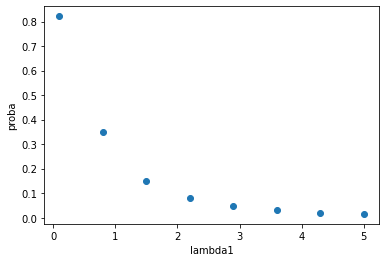

Export PDF : img/2_Weibull/var_lambda2.pdf



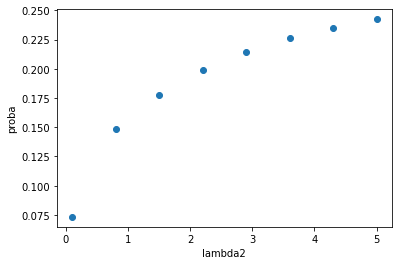

Export PDF : img/2_Weibull/var_k1.pdf



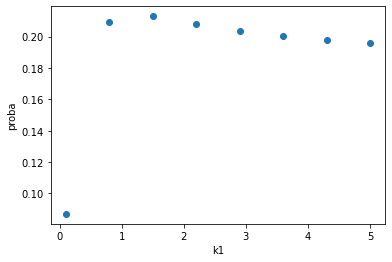

Export PDF : img/2_Weibull/var_k2.pdf



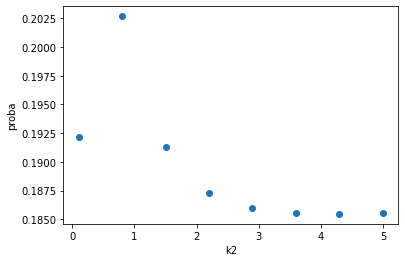

Export PDF : img/2_Weibull/var_n.pdf



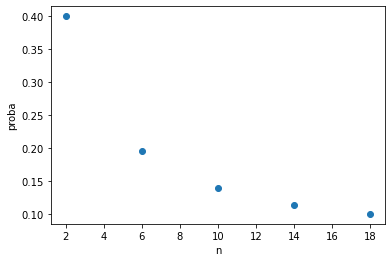

Export PDF : img/2_Weibull/var_t.pdf



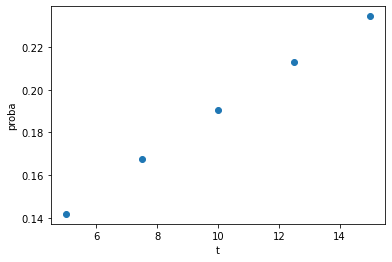

In [21]:
for column in ['lambda1', 'lambda2', 'k1', 'k2', 'n', 't']:
    groupby = df_resul.groupby(by=column).mean()
    
    plt.scatter(groupby.index, groupby.proba)
    plt.ylabel("proba")
    plt.xlabel(column)
    pdf.export(f"var_{column}")
    plt.show()

### Comparaison de l'erreur pour les deux lois 
On décide de comparer les probabilités obtenus par deux simulations, l'une utilisant des lois exponentielle, la seconde des lois de Weibull. Pour pouvoir comparer les probabilités on utilise des lois avec des espérances similaires, mais des variances différentes.  
On choisit d'avoir une variance plus faible pour la loi du temps de prise en charge.  

In [22]:
from scipy.special import gamma, factorial

In [23]:
def lambda_eq(lambda_,k):
    return((lambda_*gamma(1+1/k)))

In [24]:
%%time
proba_N_simul_v0(0.5, 1, 1, 8, 6, 5, N_simul=1000, multiproc=False)

CPU times: user 720 ms, sys: 3.65 ms, total: 724 ms
Wall time: 721 ms


0.447

In [25]:
%%time
proba_N_simul_v0(0.5, lambda_eq(1,8), 1, 1, 6, 5, N_simul=1000, multiproc=False)

CPU times: user 722 ms, sys: 3.82 ms, total: 726 ms
Wall time: 723 ms


0.439

Les probabilités étant similaires, on décide comparer également les intervalles de confiances pour les probabilités.  
On réalise pour cela plusieurs estimations et on trace ensuite un boxplot des probabilités estimées.

In [26]:
nb = 10000
if LOW_CPU:
    nb = 400
if not MULTIPROCESSING:
    nb = 100

def f_weibull(i):
    return {"proba": proba_N_simul_v0(0.5, 1, 1, 8, 6, 5, N_simul=1000, multiproc=False),
            "méthode": "Weibull"}
if MULTIPROCESSING:
    resultat_weibull = p_map(f_weibull, range(nb))
else:
    resultat_weibull = list(map(f_weibull, range(nb)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
def f_exp(i):
    return {"proba": proba_N_simul_v0(0.5, lambda_eq(1,8), 1, 1, 6, 5, N_simul=1000, multiproc=False),
            "méthode": "Exp"}
if MULTIPROCESSING:
    resultat_exp = p_map(f_exp, range(nb))
else:
    resultat_exp = list(map(f_exp, range(nb)))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
df_prob = pd.DataFrame(resultat_weibull+resultat_exp)
df_prob

,proba,méthode
0,0.439,Weibull
1,0.441,Weibull
2,0.431,Weibull
3,0.487,Weibull
4,0.439,Weibull
...,...,...
19995,0.445,Exp
19996,0.418,Exp
19997,0.433,Exp
19998,0.437,Exp


Export PDF : img/2_Weibull/06.pdf



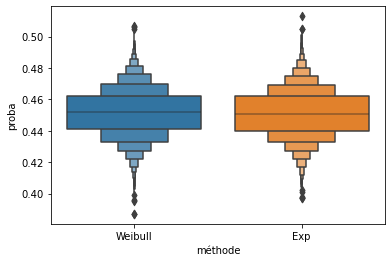

In [29]:
sns.boxenplot(data=df_prob,x="méthode",y="proba")
pdf.export()

In [30]:
df_prob[df_prob["méthode"]=="Weibull"]["proba"].describe()

count    10000.000000
mean         0.451460
std          0.015901
min          0.387000
25%          0.441000
50%          0.452000
75%          0.462000
max          0.507000
Name: proba, dtype: float64

In [31]:
df_prob[df_prob["méthode"]=="Exp"]["proba"].describe()

count    10000.000000
mean         0.450896
std          0.015843
min          0.397000
25%          0.440000
50%          0.451000
75%          0.462000
max          0.513000
Name: proba, dtype: float64

In [32]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:28:47
